In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import googlemaps
from datetime import datetime

## FUNCTIONS 

In [14]:
def keep_numeric(x):
    return re.sub("[^0-9]", "", x)

In [20]:
def replace_price(x):
    if x == "£":
        return 1
    if x == "££": 
        return 2 
    if x == "£££": 
        return 3 
    if x == "££££": 
        return 4 

In [381]:
#Function latitude/ longitude

def latitude(column):
    key = pd.read_csv("../raw_data/api_key.csv", header=None)
    key = key.loc[0,0]
    gmaps = googlemaps.Client(key=key)
    # Geocoding an address
    geocode_result = gmaps.geocode(column)
    return float(geocode_result[0]['geometry']['location']['lat'])

def longitude(column):
    key = pd.read_csv("../raw_data/api_key.csv", header=None)
    key = key.loc[0,0]
    gmaps = googlemaps.Client(key=key)
    # Geocoding an address
    geocode_result = gmaps.geocode(column)
    return float(geocode_result[0]['geometry']['location']['lng'])

In [382]:
def get_postal_code(x):
    return re.findall(r'\d{4}-\d{3}', x)[0]

In [470]:
#Function labels 
def labels_eat_on_site (x):
    if 'dine-in' in x:
        return 1 
    else: 
        return 0
    
def labels_delivery (x):
    if ('delivery' in x) or ('no-contact delivery' in x):
        return 1
    else: 
        return 0
    
def labels_takeaway (x):
    if ('takeaway' in x):
        return 1
    else: 
        return 0

def labels_drive_thru (x):
    if ('drive-through' in x):
        return 1
    else: 
        return 0
    
def labels_no_del(x):
    if ( 'no delivery' in (x)):
        return 1
    else: 
        return 0    
    
def labels_curbside(x):
    if ( 'curbside pickup' in (x)):
        return 1
    else: 
        return 0

In [385]:
#post code format for post codes table 
def post_code2(x):
    return (x[0:4]+'-'+x[4:])  

## Preprocessing of columns

In [641]:
# Importing the data in form 1 and basic preprocessing 
#data= pd.read_csv("../raw_data/restaurants2 - Copy.csv", header= None)
#data=data.rename(columns={0:"Index", 1:"name" , 2:"type", 3:"description", 4:"rating", 5:"review_count", 6: "price", 7:"address", 8:"label"})
#data=data.drop(columns='Index') # Check whether to keep it or not 

In [642]:
# Importing the data in form 2 and basic preprocessing (this takes a bit of time)
data= pd.read_csv("../raw_data/restaurants_clean.csv")
data=data.rename(columns={0:"Index", 'restaurant_name':"name" , 'restaurant_category':"type", 'restaurant_description':"description", 'restaurant_rating':"rating", 'restaurant_comment_number':"review_count", 'restaurant_price_range': "price", 'restaurant_location':"address", 'restaurant_services':"label"})
data=data.drop(columns=['Index', 'Unnamed: 0']) # Check whether to keep it or not 
data=data.dropna(subset=['rating']) # dropping rows with no rating 
data.label=data.label.fillna(value='Dine-in')# replacing rows with no label by ['Dine-in']
data.type=data.type=data.label.fillna(value='Restaurant')

# Column rating 
data.rating=pd.to_numeric(data.rating, downcast="float")

# Column review_count 
data.review_count=data.review_count.map(keep_numeric)
data.review_count=pd.to_numeric(data.review_count, downcast="float")

#Column price 
data.price = data.price.map(replace_price)

#Adress into latitude and longitude 
data['latitude']=data.address.map(latitude)
data['longitude']=data.address.map(longitude)

# handling the label 
data.label= data['label'].str.lower()
data['dine_in']=data.label.map(labels_eat_on_site)
data['takeaway']=data.label.map(labels_takeaway)
data['delivery']=data.label.map(labels_delivery)
data['drive_through']=data.label.map(labels_drive_thru)
data['no_del_exp']=data.label.map(labels_no_del)
data['curb_pickup']=data.label.map(labels_curbside)

# handling the type
data.type=data.type.replace('restaurant', '', regex=True)
data.type= data.type.str.lower()

#add postal code
data['postal_code']=data.address.map(get_postal_code)

#handling remaining null values (price):
data.price=data.price.fillna(value=np.mean(data.price)).astype(int) ## CHOICE 1 TO BE CONFIRMED: FILLING THE NA ON PRICE WITH AVERAGE

In [643]:
data.head()

,name,type,description,rating,review_count,price,address,label,latitude,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code
0,Augusto Lisboa,"['dine-in', 'takeaway', 'no delivery']","Hip brunch eatery serving savory toasts, banan...",4.8,1032.0,2,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",38.714376,-9.130176,1,1,1,0,1,0,1100-491
1,Tiffin Cafe & Restaurant Lisboa,"['dine-in', 'takeaway', 'delivery']",NaN,4.9,139.0,2,"R. do Conde 32, 1200-637 Lisboa, Portugal","['dine-in', 'takeaway', 'delivery']",38.706143,-9.161868,1,1,1,0,0,0,1200-637
2,Crisfama,"['dine-in', 'takeaway', 'no delivery']",NaN,4.8,649.0,1,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['dine-in', 'takeaway', 'no delivery']",38.717502,-9.120669,1,1,1,0,1,0,1100-188
3,Alma,"['dine-in', 'no takeaway', 'no delivery']",High-end restaurant with avant-garde local mea...,4.8,953.0,4,"R. Anchieta 15, 1200-224 Lisboa, Portugal","['dine-in', 'no takeaway', 'no delivery']",38.710140,-9.141088,1,1,1,0,1,0,1200-224
4,Restaurant CHULHO & Bar,"['dine-in', 'takeaway', 'delivery']",NaN,4.9,180.0,2,"R. de São João da Mata 82, 1200-850 Lisboa, Po...","['dine-in', 'takeaway', 'delivery']",38.707959,-9.158521,1,1,1,0,0,0,1200-850


## Prepropressing of postal codes table and merging with original database

In [644]:
data_post=pd.read_csv("../raw_data/cod_post_freg_matched.txt")
data_post.CodigoPostal=data_post.CodigoPostal.astype(str)
data_post.CodigoPostal=data_post.CodigoPostal.map(post_code2)
data_post=data_post[['CodigoPostal', 'Concelho', 'Freguesia']]
data_post=data_post.rename(columns={'CodigoPostal':'postal_code', 'Distrito': 'district', 'Concelho': 'municipality', 'Freguesia': 'neighborhood'} )

In [645]:
data=data.merge(data_post, on='postal_code', how='left')

In [646]:
data.head(2)

,name,type,description,rating,review_count,price,address,label,latitude,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
0,Augusto Lisboa,"['dine-in', 'takeaway', 'no delivery']","Hip brunch eatery serving savory toasts, banan...",4.8,1032.0,2,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",38.714376,-9.130176,1,1,1,0,1,0,1100-491,Lisboa,Graça
1,Tiffin Cafe & Restaurant Lisboa,"['dine-in', 'takeaway', 'delivery']",NaN,4.9,139.0,2,"R. do Conde 32, 1200-637 Lisboa, Portugal","['dine-in', 'takeaway', 'delivery']",38.706143,-9.161868,1,1,1,0,0,0,1200-637,Lisboa,Prazeres


## Exploration

### overall ratings 

(array([ 2.,  0.,  2.,  2.,  3.,  7., 27., 44., 34., 13.]),
 array([3.2 , 3.38, 3.56, 3.74, 3.92, 4.1 , 4.28, 4.46, 4.64, 4.82, 5.  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

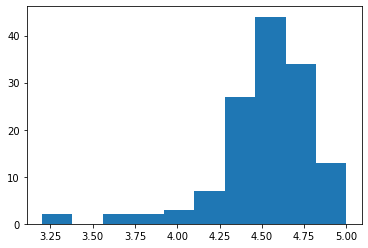

In [516]:
# Repartition of reviews
plt.hist(data.rating)

average number of reviews per store: 708.5821
Some outliers with many reviews: 


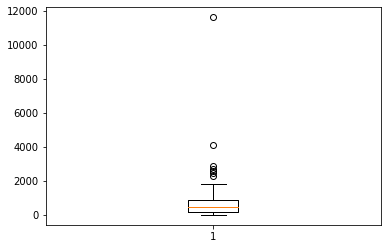

In [517]:
# number of reviews per store: 
plt.boxplot(data.review_count)

print('average number of reviews per store:', data.review_count.mean())
print('Some outliers with many reviews: ')

### Information about type of food

/Users/louisecaucheteux/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/louisecaucheteux/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/louisecaucheteux/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will

<AxesSubplot:title={'center':'Average price for each type of restaurant'}, xlabel='type', ylabel='price'>

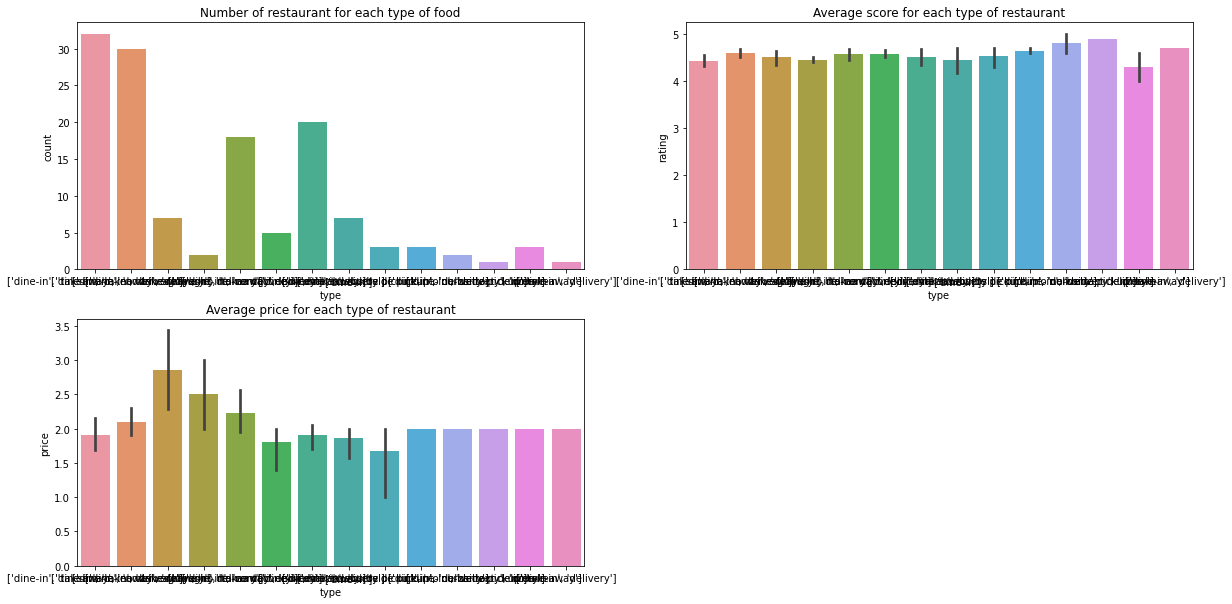

In [518]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.title('Number of restaurant for each type of food')
sns.countplot(data.type)

plt.subplot(2,2,2)
plt.title('Average score for each type of restaurant')
sns.barplot(data.type, data.rating)

plt.subplot(2,2,3)
plt.title('Average price for each type of restaurant')
sns.barplot(data.type, data.price)

#plt.subplot(2,2,3)
#plt.title('Most common localization for each type of restaurant')
#data.groupby(data.type).mean()

### information about neighborhood

/Users/louisecaucheteux/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/louisecaucheteux/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/louisecaucheteux/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'Graça'),
  Text(1, 0, 'Prazeres'),
  Text(2, 0, 'Santa Engrácia'),
  Text(3, 0, 'São Paulo'),
  Text(4, 0, 'Lapa'),
  Text(5, 0, 'Santa Catarina'),
  Text(6, 0, 'Alto do Pina'),
  Text(7, 0, 'Encarnação'),
  Text(8, 0, 'Alcântara'),
  Text(9, 0, 'Santa Isabel'),
  Text(10, 0, 'Socorro'),
  Text(11, 0, 'Anjos'),
  Text(12, 0, 'Santo Estevão'),
  Text(13, 0, 'São Jorge de Arroios'),
  Text(14, 0, 'Pena'),
  Text(15, 0, 'Madalena'),
  Text(16, 0, 'São Vicente de Fora'),
  Text(17, 0, 'Santos-o-Velho'),
  Text(18, 0, 'Mercês'),
  Text(19, 0, 'Coração de Jesus'),
  Text(20, 0, 'São José'),
  Text(21, 0, 'Sacramento'),
  Text(22, 0, 'São Miguel'),
  Text(23, 0, 'Mártires'),
  Text(24, 0, 'São Sebastião da Pedreira'),
  Text(25, 0, 'Nossa Senhora de Fátima'),
  Text(26, 0, 'São Cristóvão'),
  Text(27, 0, 'São Mamede'),
  Text(28, 0, 'S

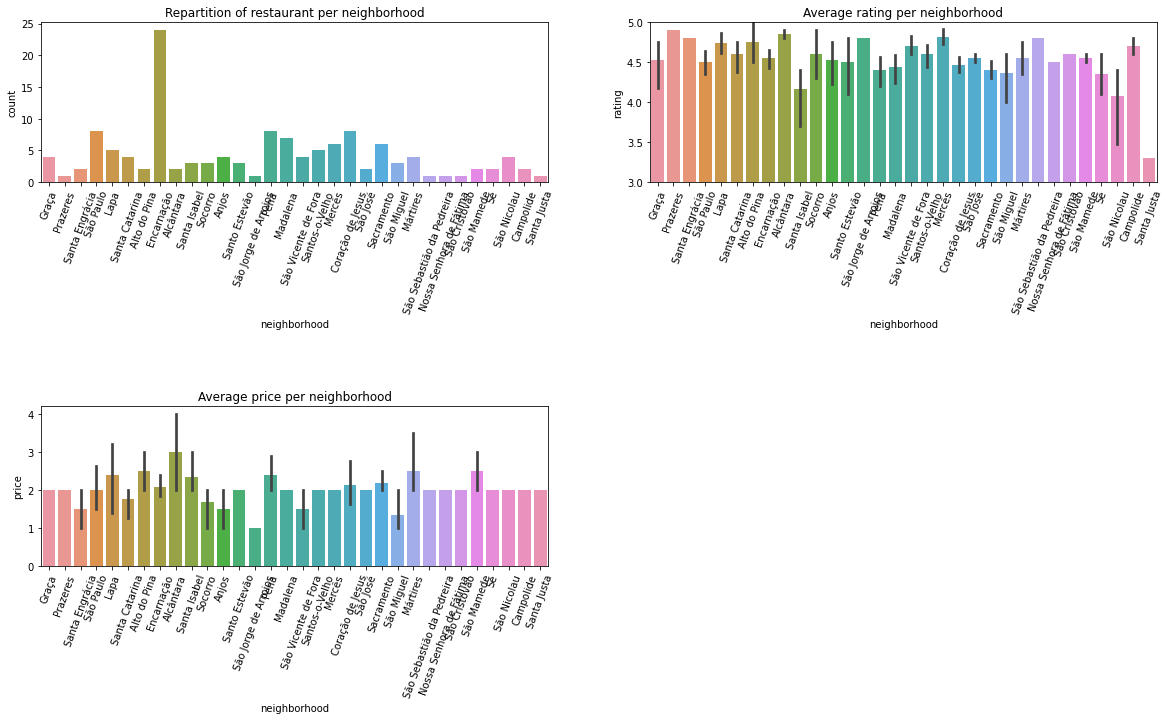

In [533]:
plt.figure(figsize=(20,10))

# Repartition of restaurant per neighborhood
plt.subplot(3,2,1)
plt.title('Repartition of restaurant per neighborhood')
sns.countplot(data.neighborhood)
plt.xticks(rotation=70)

# Average rating per neighborhood 
plt.subplot(3,2,2)
plt.title('Average rating per neighborhood')
sns.barplot(data.neighborhood, data.rating)
plt.xticks(rotation=70)
plt.ylim([3,5])
# Average price per neighborhood 
plt.subplot(3,2,5)
plt.title('Average price per neighborhood')
sns.barplot(data.neighborhood, data.price)
plt.xticks(rotation=70)

In [532]:
exct1=data[['neighborhood','takeaway', 'delivery', 'drive_through', 'curb_pickup']].groupby('neighborhood').mean()
exct1

,takeaway,delivery,drive_through,curb_pickup
neighborhood,,,,
Alcântara,0.000000,1.000000,0.000,0.000000
Alto do Pina,0.000000,0.500000,0.500,0.500000
Anjos,1.000000,0.750000,0.000,0.000000
Campolide,1.000000,1.000000,0.000,0.000000
Coração de Jesus,0.750000,0.875000,0.000,0.125000
Encarnação,0.708333,0.750000,0.000,0.041667
Graça,0.500000,1.000000,0.000,0.250000
Lapa,1.000000,1.000000,0.000,0.000000
Madalena,0.857143,0.857143,0.000,0.000000


### Correlation and pairplot

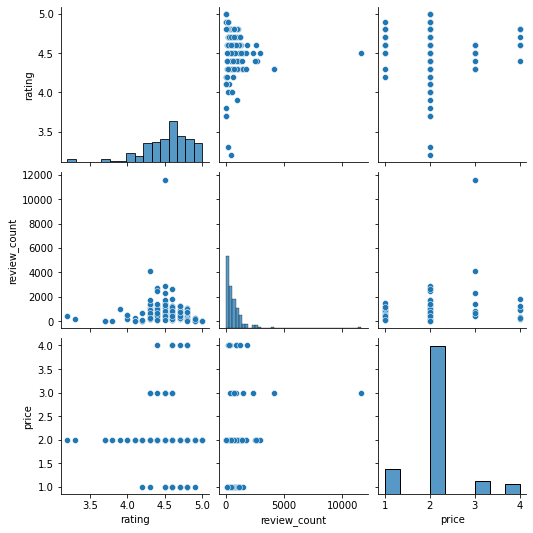

In [520]:
sns.pairplot(data[['rating', 'review_count', 'price']])

## Labels

In [522]:
data.label.value_counts()

['dine-in', 'takeaway', 'no delivery']                   32
['dine-in', 'takeaway', 'delivery']                      30
['dine-in', 'takeaway']                                  20
['dine-in', 'no delivery']                               18
['dine-in', 'no takeaway', 'no delivery']                 7
['dine-in']                                               7
['dine-in', 'takeaway', 'no-contact delivery']            5
['dine-in', 'curbside pickup', 'no delivery']             3
['dine-in', 'curbside pickup', 'no-contact delivery']     3
dine-in                                                   3
['dine-in', 'drive-through', 'no-contact delivery']       2
['dine-in', 'curbside pickup']                            2
['dine-in', 'delivery', 'no takeaway']                    1
['dine-in', 'delivery']                                   1
Name: label, dtype: int64

In [525]:
data.groupby('label').mean()
#regions = countries_df.groupby('Region')

,rating,review_count,price,latitude,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup
label,,,,,,,,,,,
"['dine-in', 'curbside pickup', 'no delivery']",4.533333,529.000000,1.666667,38.711922,-9.141371,1.0,0.0,1.0,0.0,1.0,1.0
"['dine-in', 'curbside pickup', 'no-contact delivery']",4.633333,929.333313,2.000000,38.715512,-9.140606,1.0,0.0,1.0,0.0,0.0,1.0
"['dine-in', 'curbside pickup']",4.800000,177.500000,2.000000,38.722725,-9.138665,1.0,0.0,0.0,0.0,0.0,1.0
"['dine-in', 'delivery', 'no takeaway']",4.900000,115.000000,2.000000,38.707571,-9.141737,1.0,1.0,1.0,0.0,0.0,0.0
"['dine-in', 'delivery']",4.700000,528.000000,2.000000,38.713975,-9.144031,1.0,0.0,1.0,0.0,0.0,0.0
"['dine-in', 'drive-through', 'no-contact delivery']",4.450000,6095.500000,2.500000,38.723932,-9.138397,1.0,0.0,1.0,1.0,0.0,0.0
"['dine-in', 'no delivery']",4.566667,398.222229,2.222222,38.712492,-9.147020,1.0,0.0,1.0,0.0,1.0,0.0
"['dine-in', 'no takeaway', 'no delivery']",4.500000,607.571411,2.857143,38.710945,-9.141114,1.0,1.0,1.0,0.0,1.0,0.0
"['dine-in', 'takeaway', 'delivery']",4.593333,905.966675,2.100000,38.714796,-9.147056,1.0,1.0,1.0,0.0,0.0,0.0


In [547]:
data23=data.groupby('takeaway').mean()
data23

,rating,review_count,price,latitude,longitude,dine_in,delivery,drive_through,no_del_exp,curb_pickup
takeaway,,,,,,,,,,
0,4.538462,733.102539,2.076923,38.714578,-9.142217,1.0,0.692308,0.051282,0.538462,0.205128
1,4.520000,698.515808,2.031579,38.714074,-9.143349,1.0,0.789474,0.000000,0.410526,0.000000


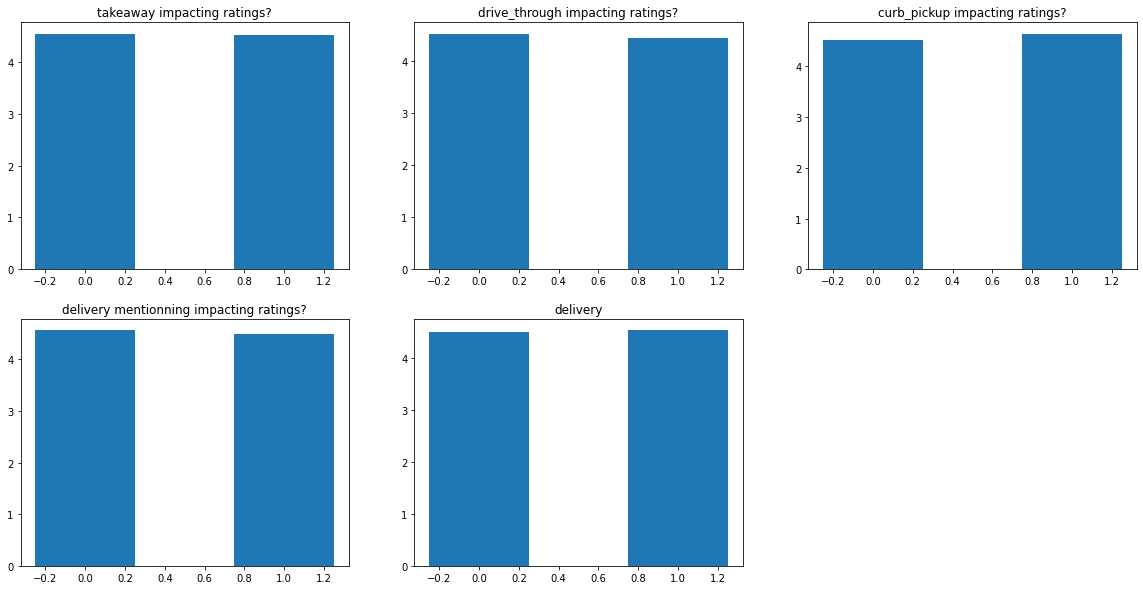

In [587]:
plt.figure(figsize=(20,10))

# takeaway
data23=data.groupby('takeaway').mean()
plt.subplot(2,3,1)
plt.title('takeaway impacting ratings?')
plt.bar(x= (0,1), height=data23.rating, width=0.5)
#plt.ylim=[4,5]

# drive_through
data24=data.groupby('drive_through').mean()
plt.subplot(2,3,2)
plt.title('drive_through impacting ratings?')
plt.bar(x= (0,1), height=data24.rating, width=0.5)
#plt.ylim=[4,5]

# curb_pickup
data25=data.groupby('curb_pickup').mean()
plt.subplot(2,3,3)
plt.title('curb_pickup impacting ratings?')
plt.bar(x= (0,1), height=data25.rating, width=0.5)
#plt.ylim=[4,5]

# Restaurant explicitely mentinning no delivery
data26=data.groupby('no_del_exp').mean()
plt.subplot(2,3,4)
plt.title('delivery mentionning impacting ratings?')
plt.bar(x= (0,1), height=data26.rating, width=0.5)
#plt.ylim=[4,5]

# delivery
data27=data.groupby('delivery').mean()
plt.subplot(2,3,5)
plt.title('delivery')
plt.bar(x= (0,1), height=data27.rating, width=0.5)
plt.ylim=[4,5]

## Mapping of coordinates of restaurant with folium 

In [588]:
import os 
import folium

In [626]:
latlonname= zip(data['latitude'],data['longitude'], data['name'], data['price'], data['rating'], data['type'])

m = folium.Map(location=[38.709223,  -9.1383], titles='small businesses', zoom_start=13.45)

for coord in latlonname:
    folium.Marker(location=[coord[0], coord[1]], tooltip=str,popup= f'\n Name: {coord[2]} \n Price ($): {coord[3]} \n Rating:{coord[4]}\n Type:{coord[5]}').add_to(m)

m
#Put only 2 digit after coma

In [630]:
data.price(data.price==1)

TypeError: 'Series' object is not callable

In [637]:
data

,name,type,description,rating,review_count,price,address,label,latitude,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code


In [638]:
## Select the criteria you want to plot by selecting the data

neighborhood=''

data_lowprice=data[data['price'] <= 2]
data_highprice=data[data['price'] >= 2]

data_graca=data[data['neighborhood'] == 'Graça']
best_restaurant_graca=data_graca[data['rating'] >=4]

#your_data=
#data_highprice=data[data['price'] >= 2]

#Select the data you want above --> 
data=data_highprice
#data=your_data

latlonname= zip(data['latitude'],data['longitude'], data['name'], data['price'], data['rating'], data['type'])

m = folium.Map(location=[38.709223,  -9.1383], titles='small businesses', zoom_start=13.45)

for coord in latlonname:
    folium.Marker(location=[coord[0], coord[1]], tooltip=str,popup= f'\n Name: {coord[2]} \n Price ($): {coord[3]} \n Rating:{coord[4]}\n Type:{coord[5]}').add_to(m)

m
#Put only 2 digit after coma

## TO DO:

Update the key with Jamie code OK
Vizualization for :
- Overall OK
- Neigh OK 
- Type of food OK 

on maps: 
- Overall map OK 
- Map with 2 different colours location and price
- Map with 2 different colours location and score>mean score, score < Mean score 
- Map with different colours: locations with deliveries,... 
- Map with fake filters 

## OUT: Prepropressing of POST CODE table and merging with method 1 

In [173]:
codigos=codigos[codigos['cod_distrito']==11]
codigos=codigos[['cod_distrito', 'cod_concelho', 'nome_localidade', 'num_cod_postal' , 'ext_cod_postal', 'desig_postal']]
codigos['num_cod_postal']=codigos['num_cod_postal'].astype(str)
codigos[’'ext_cod_postal']=codigos['ext_cod_postal'].astype(str)
codigos.ext_cod_postal=codigos.ext_cod_postal.map(ext_cod_format)
codigos['postal_code']=codigos['num_cod_postal'].astype(str) + '-' + codigos['ext_cod_postal'].astype(str) 
codigos=codigos.drop(columns=['num_cod_postal', 'ext_cod_postal'])

In [175]:
codigos.head()

,cod_distrito,cod_concelho,nome_localidade,desig_postal,postal_code
126360,11,1,Abrigada,ABRIGADA,2580-010
126361,11,1,Abrigada,ABRIGADA,2580-001
126362,11,1,Abrigada,ABRIGADA,2580-011
126363,11,1,Abrigada,ABRIGADA,2580-119
126364,11,1,Abrigada,ABRIGADA,2580-115


In [182]:
data=data.merge(codigos, on='postal_code')

In [184]:
data

,name,type,description,rating,review_count,price,address,label,latitude,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,postal_code,cod_distrito,cod_concelho,nome_localidade,desig_postal
0,Augusto Lisboa,brunch,"Hip brunch eatery serving savory toasts, banan...",4.8,1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",None,None,1,1,1,0,1,1100-491,11,6,Lisboa,LISBOA
1,Tiffin Cafe & Restaurant Lisboa,brunch,NaN,4.9,139.0,2.0,"R. do Conde 32, 1200-637 Lisboa, Portugal","['dine-in', 'takeaway', 'delivery']",None,None,1,1,1,0,0,1200-637,11,6,Lisboa,LISBOA
2,Crisfama,,NaN,4.8,649.0,1.0,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['dine-in', 'takeaway', 'no delivery']",None,None,1,1,1,0,1,1100-188,11,6,Lisboa,LISBOA
3,Alma,fine dining,High-end restaurant with avant-garde local mea...,4.8,953.0,4.0,"R. Anchieta 15, 1200-224 Lisboa, Portugal","['dine-in', 'no takeaway', 'no delivery']",None,None,1,1,1,0,1,1200-224,11,6,Lisboa,LISBOA
4,Restaurant CHULHO & Bar,,NaN,4.9,180.0,NaN,"R. de São João da Mata 82, 1200-850 Lisboa, Po...","['dine-in', 'takeaway', 'delivery']",None,None,1,1,1,0,0,1200-850,11,6,Lisboa,LISBOA
5,Jam Club,,NaN,4.8,664.0,1.0,"Tv. Inglesinhos 49, 1200-223 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",None,None,1,1,1,0,1,1200-223,11,6,Lisboa,LISBOA
6,Ramiro,seafood,"Relaxed, informal 3-floor seafood and beer dri...",4.5,11612.0,3.0,"Av. Alm. Reis 1 H, 1150-007 Lisboa, Portugal","['dine-in', 'drive-through', 'no-contact deliv...",None,None,1,0,1,1,0,1150-007,11,6,Lisboa,LISBOA
7,Belcanto,,"Chic, wood-paneled dining room serving modern ...",4.6,865.0,4.0,"R. Serpa Pinto 10A, 1200-026 Lisboa, Portugal","['dine-in', 'no takeaway', 'no delivery']",None,None,1,1,1,0,1,1200-026,11,6,Lisboa,LISBOA
8,Feitoria,portuguese,"Portuguese fare served in a light-filled, whit...",4.8,357.0,4.0,"Altis Belem Hotel & Spa, Doca do Bom Sucesso, ...","['dine-in', 'no delivery']",None,None,1,0,1,0,1,1400-038,11,6,Lisboa,LISBOA
9,Feitoria,portuguese,"Portuguese fare served in a light-filled, whit...",4.8,357.0,4.0,"Altis Belem Hotel & Spa, Doca do Bom Sucesso, ...","['dine-in', 'no delivery']",None,None,1,0,1,0,1,1400-038,11,6,Lisboa,LISBOA


In [147]:
type(data.postal_code[0])

str

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for googlemaps, since package 'wheel' is not installed.
    Running setup.py install for googlemaps ... done
